In [115]:
import os

BASE_PATH = ".DATA"

try:
  from google.colab import drive

  DRIVE_PATH = os.path.join("content", "drive")

  drive.mount(DRIVE_PATH)

  BASE_PATH = os.path.join(DRIVE_PATH, "MyDrive", "TP_MACHINE_LEARNING")
except:
  pass

In [116]:
import torch

import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_recall_fscore_support

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using: {device}")

Using: cpu


In [118]:
tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_ds = datasets.ImageFolder(os.path.join(BASE_PATH, "DATASET", "test"), transform=tf)

test_loader = DataLoader(test_ds, batch_size=16)

In [119]:
RUNS_PATH = os.path.join(BASE_PATH, "BACKUP", "agregado")

In [120]:
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, len(test_ds.classes))

CHECKPOINT_PATH = os.path.join(RUNS_PATH, "CHECKPOINT.pt")

CHECKPOINT = torch.load(CHECKPOINT_PATH)

model.load_state_dict(CHECKPOINT["best_weights"], strict=False)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

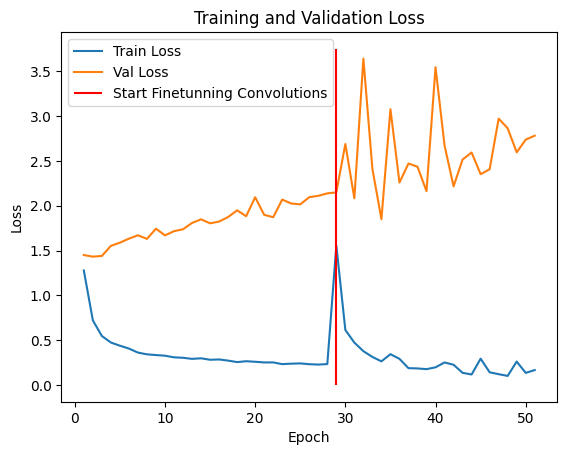

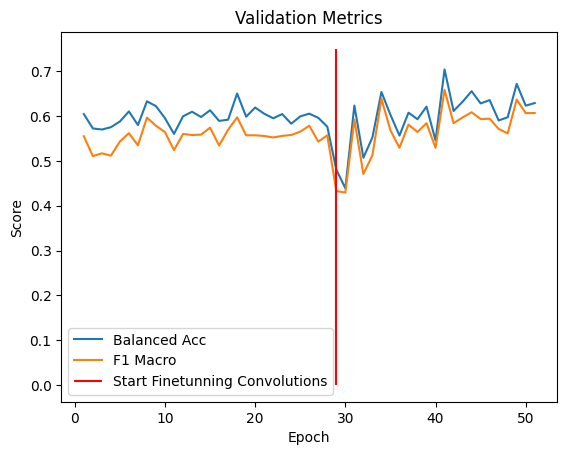

In [121]:
train = pd.read_csv(os.path.join(RUNS_PATH, "train_log.csv"))
val = pd.read_csv(os.path.join(RUNS_PATH, "val_log.csv"))

plt.figure()
plt.plot(train["epoch"], train["loss"], label="Train Loss")
plt.plot(val["epoch"], val["loss"], label="Val Loss")
plt.vlines([ 29 ], [ 0.0 ], [ 3.75 ], label="Start Finetunning Convolutions", colors="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

plt.figure()
plt.plot(val["epoch"], val["balanced_accuracy"], label="Balanced Acc")
plt.plot(val["epoch"], val["f1_macro"], label="F1 Macro")
plt.vlines([ 29 ], [ 0.0 ], [ 0.75 ], label="Start Finetunning Convolutions", colors="r")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.title("Validation Metrics")
plt.show()

In [122]:
# test_ds.classes = [
#     'banded_chlorosis',
#     'brown_spot',
#     'brownrust',
#     'dried_leaves',
#     'grassy_shot',
#     'healthy_leaves',
#     'pokkah_boeng',
#     'sett_rot',
#     'viral_disease',
#     'yellow_leaf',
#     'smut',
# ]

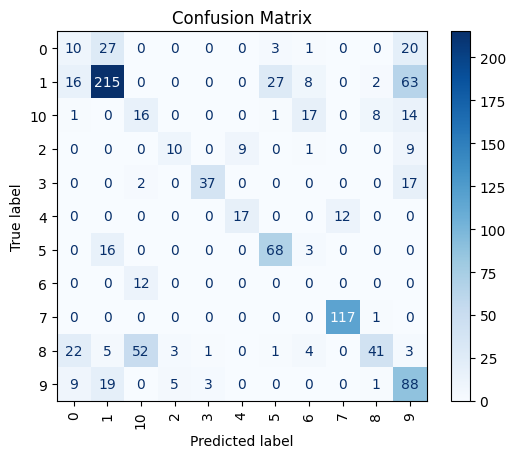

In [ ]:
y_true, y_pred = list(), list()

model.eval()

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.classes)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [124]:
y_true, y_pred = list(), list()
model.eval()

with torch.no_grad():
    for imgs, y in test_loader:
        imgs, y = imgs.to(device), y.to(device)
        outputs = model(imgs)
        y_pred.extend(outputs.argmax(1).cpu().numpy())
        y_true.extend(y.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=3))

              precision    recall  f1-score   support

           0      0.172     0.164     0.168        61
           1      0.762     0.650     0.701       331
          10      0.195     0.281     0.230        57
           2      0.556     0.345     0.426        29
           3      0.902     0.661     0.763        56
           4      0.654     0.586     0.618        29
           5      0.680     0.782     0.727        87
           6      0.000     0.000     0.000        12
           7      0.907     0.992     0.947       118
           8      0.774     0.311     0.443       132
           9      0.411     0.704     0.519       125

    accuracy                          0.597      1037
   macro avg      0.547     0.498     0.504      1037
weighted avg      0.655     0.597     0.605      1037



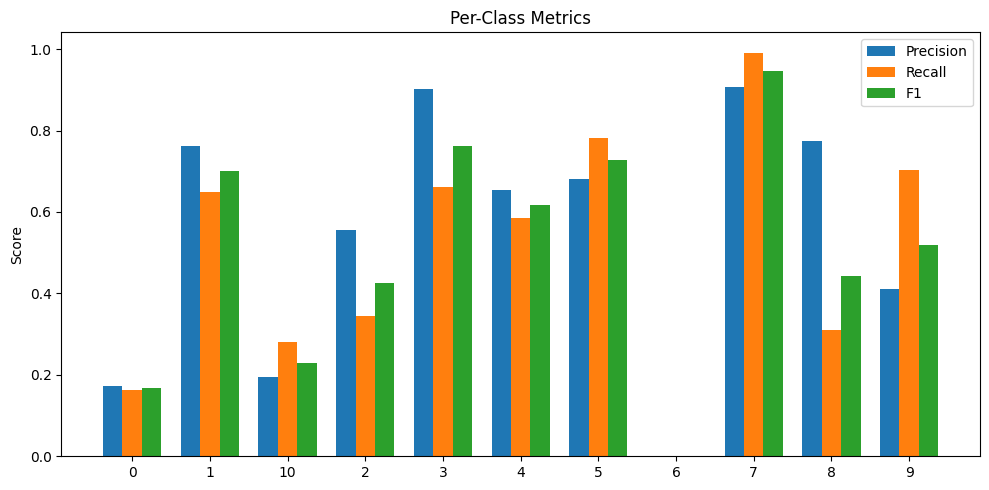

In [125]:
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)

x = np.arange(len(test_ds.classes))

plt.figure(figsize=(10,5))
plt.bar(x - 0.25, prec, 0.25, label="Precision")
plt.bar(x, rec, 0.25, label="Recall")
plt.bar(x + 0.25, f1, 0.25, label="F1")
plt.xticks(x, test_ds.classes)
plt.ylabel("Score")
plt.legend()
plt.title("Per-Class Metrics")
plt.tight_layout()
plt.show()

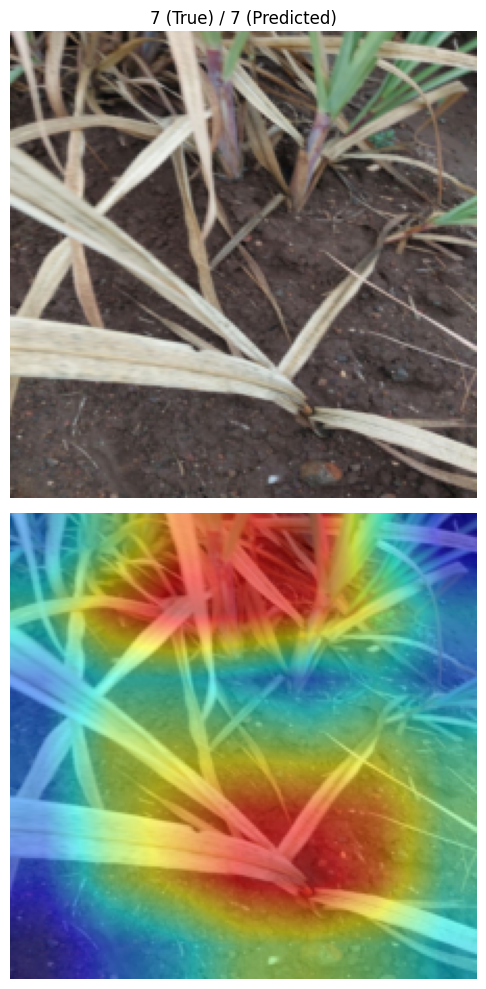

In [234]:
import numpy as np
import random
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Grad-CAM ---
target_layer = model.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

# --- Seleciona um exemplo aleatório ---
idx = random.randint(0, len(test_ds)-1)
img_tensor, true_label = test_ds[idx]

# --- Função para processar Grad-CAM e desnormalizar ---
def process_cam(img_tensor):
    img_input = img_tensor.unsqueeze(0).to(device)
    grayscale_cam = cam(input_tensor=img_input, targets=None)
    img = img_tensor.permute(1,2,0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    cam_overlay = show_cam_on_image(img, grayscale_cam[0], use_rgb=True)
    return img, cam_overlay

# --- Função para predizer a classe ---
def predict_class(img_tensor):
    img_input = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_input)
        _, pred = torch.max(outputs, 1)
    return pred.item()

# --- Processa imagem e Grad-CAM ---
img, cam_overlay = process_cam(img_tensor)
pred_label = predict_class(img_tensor)

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(5,10))

# Imagem original
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(f"{test_ds.classes[true_label]} (True) / {test_ds.classes[pred_label]} (Predicted)", fontsize=12)

# Grad-CAM
axes[1].imshow(cam_overlay)
axes[1].axis('off')

plt.tight_layout()
plt.show()


/tmp/ipykernel_519915/2253407079.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


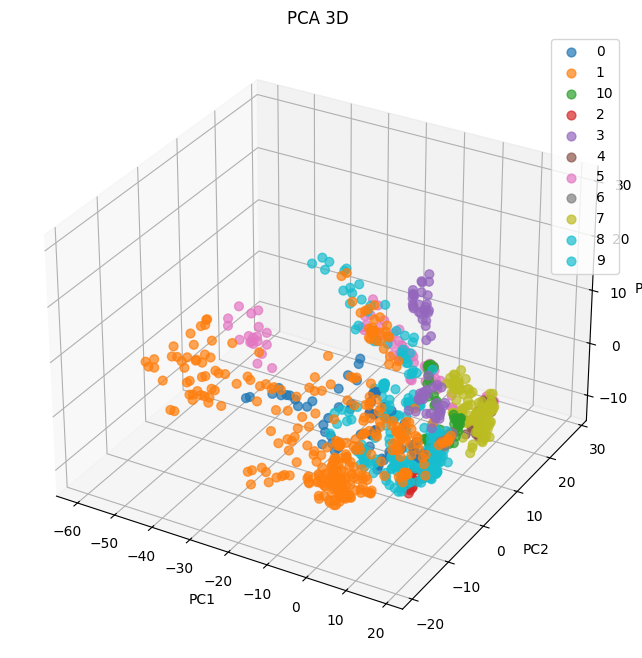

In [159]:
from sklearn.decomposition import PCA

M = models.resnet18()
M.fc = nn.Identity()  # remove a cabeça de classificação para pegar features
state_dict = CHECKPOINT["best_weights"]
M.load_state_dict(state_dict, strict=False)
M.to(device)
M.eval()


# --- Extrai features do backbone ---
features_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        feats = model(images)  # output do backbone
        features_list.append(feats.cpu())
        labels_list.append(labels)

features = torch.cat(features_list, dim=0).numpy()  # shape [N, feature_dim]
labels = torch.cat(labels_list, dim=0).numpy()      # shape [N]

# --- PCA para 3 dimensões ---
pca = PCA(n_components=3)
features_3d = pca.fit_transform(features)

# --- Plot 3D ---
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

num_classes = len(test_ds.classes)
colors = plt.cm.get_cmap('tab10', num_classes)

for cls in range(num_classes):
    idxs = labels == cls
    ax.scatter(features_3d[idxs,0], features_3d[idxs,1], features_3d[idxs,2],
               label=test_ds.classes[cls], alpha=0.7, s=40, color=colors(cls))

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 3D")
ax.legend()
plt.show()

/tmp/ipykernel_519915/3938805004.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


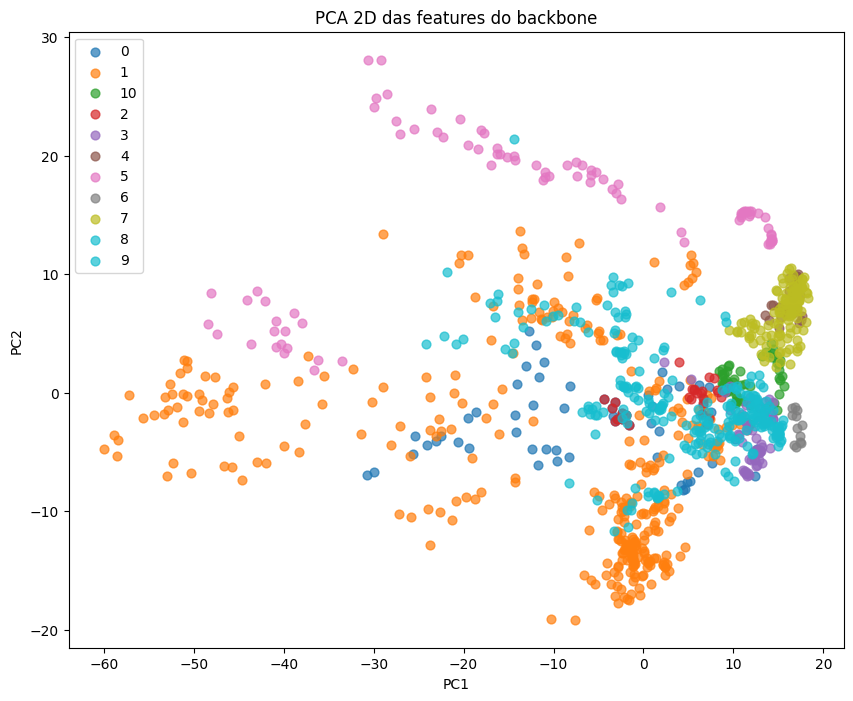

In [ ]:
features_list = list()
labels_list = list()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        feats = model(images)
        features_list.append(feats.cpu())
        labels_list.append(labels)

features = torch.cat(features_list, dim=0).numpy()
labels = torch.cat(labels_list, dim=0).numpy()

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(10,8))
num_classes = len(test_ds.classes)
colors = plt.cm.get_cmap('tab10', num_classes)

for cls in range(num_classes):
    idxs = labels == cls
    plt.scatter(features_2d[idxs,0], features_2d[idxs,1],
                label=test_ds.classes[cls], alpha=0.7, s=40, color=colors(cls))

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA 2D")
plt.legend()
plt.show()